In [3]:
import tensorflow as tf
from tensorflow import keras
import os, sys, cv2
from keras import (utils, applications, layers)
import numpy as np
import matplotlib.pyplot as plt

2024-02-14 14:45:32.193622: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-14 14:45:32.193723: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-14 14:45:32.331838: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [48]:
model = applications.ResNet50()

In [60]:
model.summary() #take output from last convolutional layers

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_9 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_9[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                       

In [93]:
def grad_cam(image_path):
    CONV = model.get_layer("conv5_block3_out")
    CONV_MODEL = tf.keras.Model(model.inputs, last_conv_layer.output)


    #Takes output from CONV_MODEL and gets predictions
    C_INPUT = tf.keras.Input(shape=last_conv_layer.output.shape[1:])
    x = C_INPUT
    for layer_name in ["avg_pool", "predictions"]:
        x = model.get_layer(layer_name)(x)
    C_MODEL = tf.keras.Model(C_INPUT, x)
    
    image = np.array(keras.preprocessing.image.load_img(image_path, target_size=(224, 224, 3)))
    
    with tf.GradientTape() as tape:
        inputs = image[np.newaxis, ...]
        CONV_OUT = CONV_MODEL(inputs)
        tape.watch(CONV_OUT)
        RESULT = C_MODEL(CONV_OUT)
        top_pred_index = tf.argmax(RESULT[0])
        top_class_channel = RESULT[:, top_pred_index]
    
    grads = tape.gradient(top_class_channel, CONV_OUT)
    
    pool_G = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    last_conv_layer_output = CONV_OUT.numpy()[0]
    pooled_grads = pool_G.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]
        
    gradcam = np.mean(last_conv_layer_output, axis=-1)
    gradcam = np.clip(gradcam, 0, np.max(gradcam)) / np.max(gradcam)
    #clipping values equivalent to ReLU, and further normalising values
    gradcam = cv2.resize(gradcam, (224, 224))
    
    plt.subplot(1,2,1)
    plt.imshow(image)
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.imshow(image)
    plt.imshow(gradcam, alpha=.5)
    plt.axis('off')

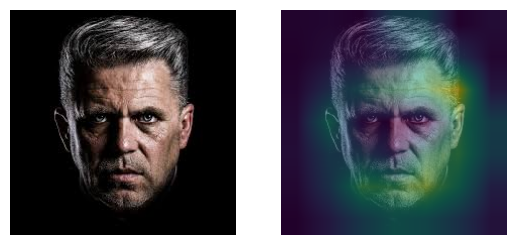

In [94]:
grad_cam('/kaggle/input/qqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqq/images (2).jpg')

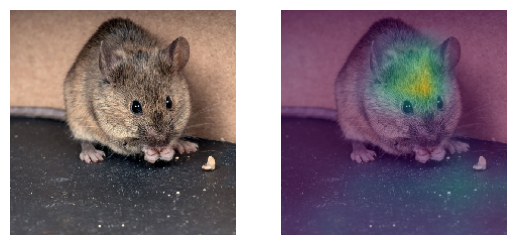

In [95]:
grad_cam('/kaggle/input/okokokokokokokokok/house-mouse.jpg')